In [45]:
# Import Libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, classification_report
from sklearn import metrics
from catboost import Pool, CatBoostClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from paramsearch import paramsearch
from itertools import product,chain

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
pd.options.mode.chained_assignment = None

In [47]:
# Load dataset
df = pd.read_excel('phishing_email_.xlsx')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11913 non-null  object
 1   Class   11929 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 186.5+ KB


In [49]:
df['Text'].isnull().sum()

16

In [50]:
df.dropna(inplace=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11913 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11913 non-null  object
 1   Class   11913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.2+ KB


In [52]:
df.Class.value_counts(normalize=True)

0    0.565685
1    0.434315
Name: Class, dtype: float64

In [53]:
df.drop_duplicates(inplace=True)
df

,Text,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,1
1,over. SidLet me know. Thx.,0
2,"Dear Friend,Greetings to you.I wish to accost ...",1
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1
4,Not a surprising assessment from Embassy.,0
...,...,...
11923,I called and was transferred to room but got n...,0
11924,Travel well. I'll look forward to hearing your...,0
11926,Follow Up Flag: Follow upFlag Status: FlaggedM...,0
11927,sbwhoeop B6Saturday January 23 2010 4:09 PMRe:...,0


Text(0, 0.5, 'classes')

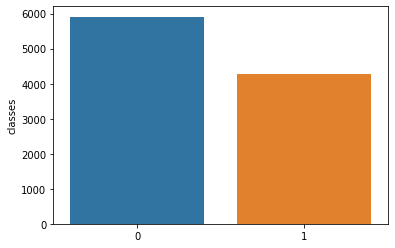

In [54]:
data=df.Class.value_counts()
sns.barplot(x=data.index,y=data)
plt.gca().set_ylabel('classes')

In [55]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

In [56]:
from io import StringIO
from html.parser import HTMLParser
import unicodedata

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
        self.start_tags = list()
        self.end_tags = list()
        self.attributes = list()
        
    def handle_data(self, d):
        self.text.write(d)
        
    def get_data(self):
        return self.text.getvalue()
    
    def is_text_html(self):
        return True if len(self.start_tags) else False

    def handle_starttag(self, tag, attrs):
        self.start_tags.append(tag)
        self.attributes.append(attrs)
        
def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', '',x)
    
def check_for_emails(x):
    return 1 if len(re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', x)) else 0


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return unicodedata.normalize("NFKD", s.get_data()).encode('ascii', 'ignore').decode('utf-8', 'ignore').replace('&nbs=p;', '').replace('=2C', ',').replace('=2E', '.').replace('=40', '@').replace('=28', '(').replace('=29', ')').replace('=5F', '_').replace('=2F', '/')

def check_for_html(text):
    s = MLStripper()
    s.feed(text)
    print(s.attributes)
    return s.is_text_html()

def check_for_urls(x):
    return 1 if len(re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)) else 0

def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', " ", x)
    x = ' '.join(x.split())
    return x

def remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])

In [57]:
df = df[df.Text.str.len() > 30]

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9116 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    9116 non-null   object
 1   Class   9116 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 213.7+ KB


In [59]:
df['Text'] = df['Text'].apply(lambda x: strip_tags(x))
#tweet['text'] = tweet['text'].apply(lambda x: remove_emails(x))

In [60]:
df['Text'].iloc[[40]].values[0]

"ct of your assistance and account provide for the tranfer, 55% will be my s=hare being the pioneer of the business while the rest 10% will be used to i=nstall a joint company in your country which will bear our name in particul=ar and whatever profit made out from this company will be used in helping t=he less privileges, mothrless babies home and charity organization in the w=orld.If you are really sure of your trustworthy, accountability and= confidentiality on his transaction, contact me and agree that you will not= change your mind to cheat or disappoint me when the fund have getting into= your account. Besides you should not entertain any fear because i am sure =of the success as an insider in the bank ok.Please reply with the a=ssurance, include your private telephone and fax numbers necessary for effe=ctive and easy communication in this transaction.As soon as you reply i wil=l let you know the next step to follow in order to finalize this transactio=n immediately.I expect your

In [61]:
df['Has_Email'] = df['Text'].apply(lambda x: check_for_emails(x))

In [62]:
df['Has_URL'] = df['Text'].apply(lambda x: check_for_urls(x))

In [63]:
df['Text'] = df['Text'].apply(lambda x: cont_to_exp(x))

In [64]:
df['Text'] = df['Text'].apply(lambda x: remove_special_chars(x))
df['Text'] = df['Text'].apply(lambda x: x.lower())

In [65]:
df['Text_Length'] = df['Text'].apply(lambda x: len(x))

In [66]:
df.describe()

,Class,Has_Email,Has_URL,Text_Length
count,9116.000000,9116.000000,9116.000000,9116.000000
mean,0.468078,0.181330,0.103335,1359.686485
std,0.499007,0.385312,0.304412,2468.580160
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,103.000000
50%,0.000000,0.000000,0.000000,473.000000
75%,1.000000,0.000000,0.000000,2196.250000
max,1.000000,1.000000,1.000000,49896.000000


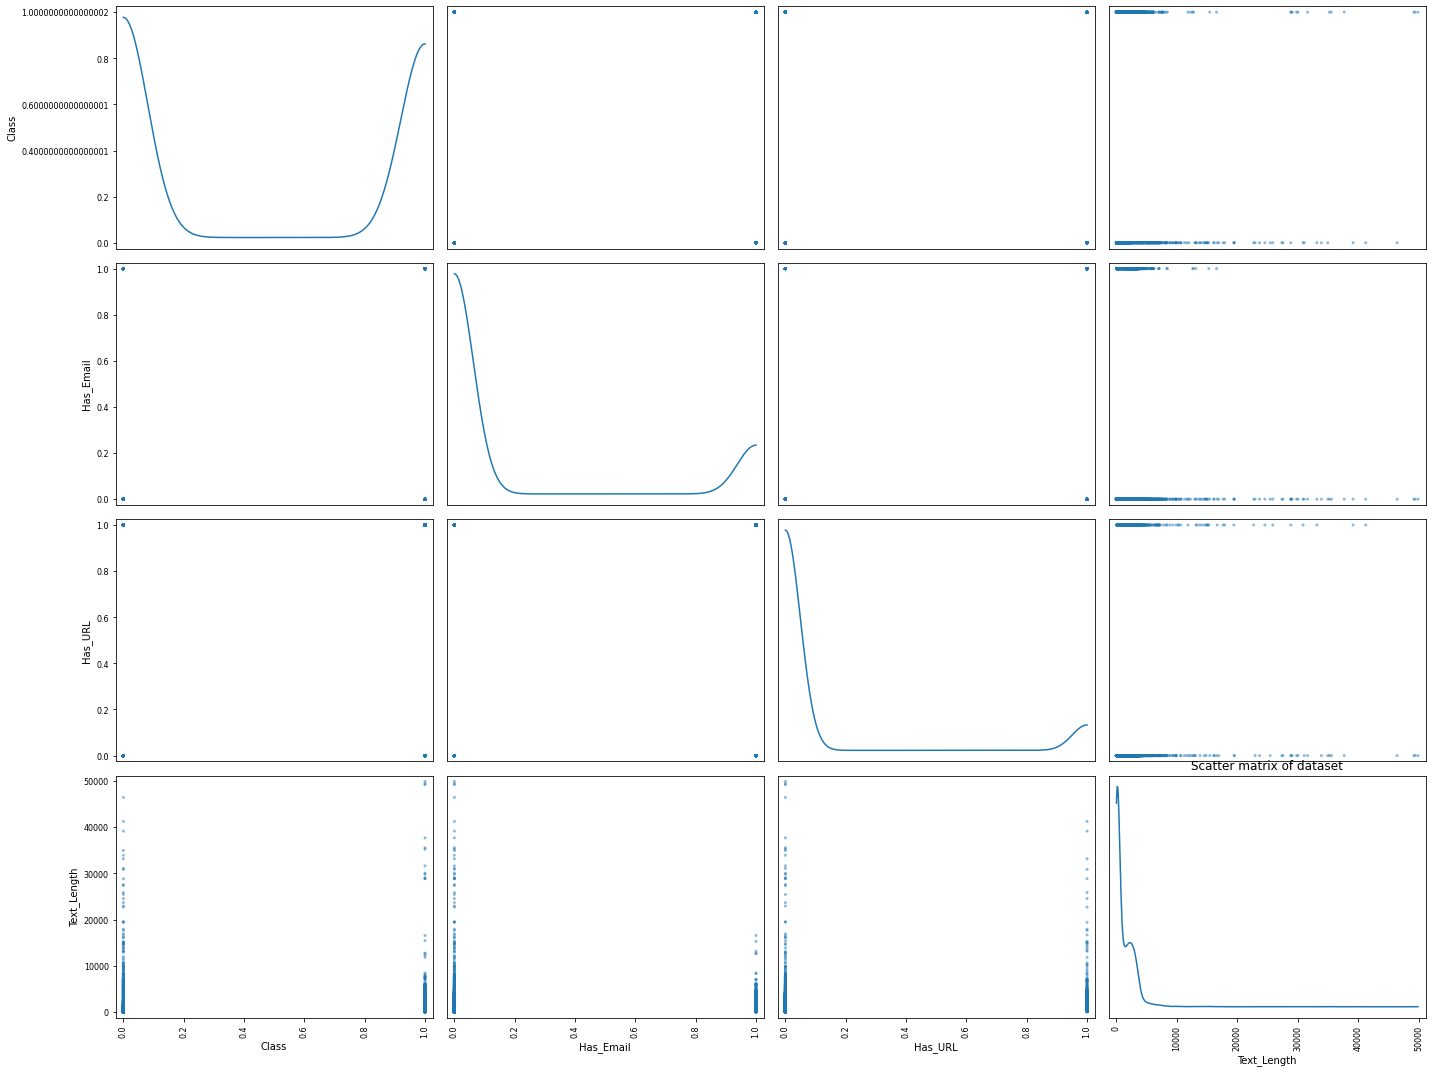

In [67]:
pd.plotting.scatter_matrix(df.loc[:,'Class':'Text_Length'], diagonal='kde', figsize=(20,15))
plt.tight_layout()
plt.title('Scatter matrix of dataset')
plt.show()

In [68]:
correlation_table = df.corr()
correlation_table

,Class,Has_Email,Has_URL,Text_Length
Class,1.000000,0.411547,0.299053,0.303650
Has_Email,0.411547,1.000000,0.103063,0.146874
Has_URL,0.299053,0.103063,1.000000,0.203213
Text_Length,0.303650,0.146874,0.203213,1.000000


Text(0.5, 1.0, 'Heatmap of the dataset correlation')

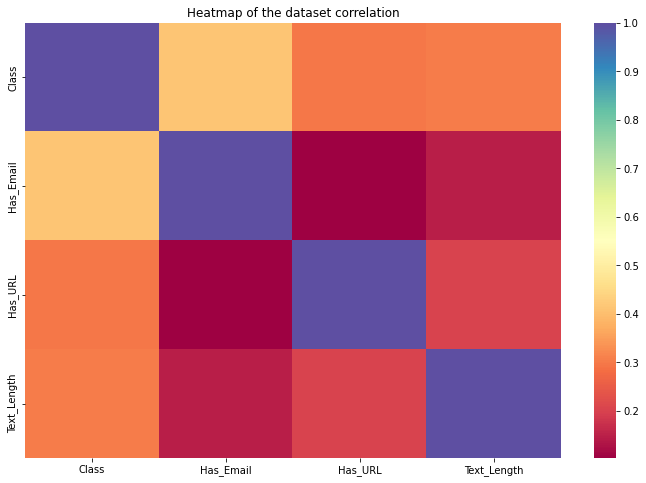

In [69]:
figsize = plt.figure(figsize=(12,8))
sns.heatmap(correlation_table, cmap='Spectral')
plt.title('Heatmap of the dataset correlation')

In [70]:
X = df.drop(['Class', 'Text_Length'], 1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [71]:
cat_features = ['Has_Email','Has_URL']
cat_dims = [X_train.columns.get_loc(i) for i in cat_features]
for header in cat_features:
    X_train[header] = X_train[header].astype('category').cat.codes
    X_train[header] = X_train[header].astype('category').cat.codes
cat_dims

[1, 2]

In [91]:
cb_params = {'depth':[3,1,2,6,4,5,7,8,9,10],
                'iterations':[250,100,500,1000,1500,2000,2500,3000],
                'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
                'l2_leaf_reg':[3,1,5,10,100],
                'border_count':[32,5,10,20,50,100,200],
                #'ctr_border_count':[50,5,10,20,100,200],
                'thread_count':4,
                'eval_metric': 'Accuracy',
                'task_type': 'GPU',
                'early_stopping_rounds': 2000,
                'use_best_model': True,
                'verbose': 500
             }

In [93]:
# this function does 3-fold crossvalidation with catboostclassifier
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True)
    res = []
    cat_features = ['Has_Email','Has_URL']
    text_features = ['Text']
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.iloc[train_index]
        test_labels = train_label.iloc[test_index]
        train_pool = Pool(
            train,
            labels,
            cat_features=cat_features,
            text_features=text_features,
            feature_names=list(train)
        )
        valid_pool = Pool(
            test,
            test_labels,
            cat_features=cat_features,
            text_features=text_features,
            feature_names=list(test)
        )
        clf = CatBoostClassifier(**params)


        clf.fit(train_pool, eval_set=valid_pool)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      #ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

bestparams = catboost_param_tune(cb_params,X_train,y_train,cat_dims)

0:	learn: 0.9626234	test: 0.9760226	best: 0.9760226 (0)	total: 24.8ms	remaining: 6.18s
249:	learn: 0.9837800	test: 0.9830748	best: 0.9835449 (142)	total: 2.66s	remaining: 0us
bestTest = 0.9835448989
bestIteration = 142
Shrink model to first 143 iterations.
0:	learn: 0.9687353	test: 0.9717913	best: 0.9717913 (0)	total: 17ms	remaining: 4.24s
249:	learn: 0.9795487	test: 0.9741420	best: 0.9741420 (118)	total: 2.59s	remaining: 0us
bestTest = 0.974141984
bestIteration = 118
Shrink model to first 119 iterations.
0:	learn: 0.9687353	test: 0.9708510	best: 0.9708510 (0)	total: 10.4ms	remaining: 2.58s
249:	learn: 0.9776681	test: 0.9783733	best: 0.9783733 (222)	total: 2.59s	remaining: 0us
bestTest = 0.9783732957
bestIteration = 222
Shrink model to first 223 iterations.
0.9786867262184611 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 

In [94]:
bestparams

{'depth': 3,
 'iterations': 1000,
 'learning_rate': 0.2,
 'l2_leaf_reg': 3,
 'border_count': 20,
 'thread_count': 4,
 'eval_metric': 'Accuracy',
 'task_type': 'GPU',
 'early_stopping_rounds': 2000,
 'use_best_model': True,
 'verbose': 500}

In [95]:
cat_features = ['Has_Email','Has_URL']
text_features = ['Text']

In [96]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)

class_weight = [5,4]
model = CatBoostClassifier(**bestparams)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.9771196	test: 0.9820841	best: 0.9820841 (0)	total: 26.6ms	remaining: 26.6s
500:	learn: 0.9938881	test: 0.9864717	best: 0.9864717 (178)	total: 12.8s	remaining: 12.8s
999:	learn: 0.9942015	test: 0.9868373	best: 0.9868373 (971)	total: 25.7s	remaining: 0us
bestTest = 0.9868372943
bestIteration = 971
Shrink model to first 972 iterations.


In [97]:
pred = model.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1426
           1       0.98      0.99      0.99      1309

    accuracy                           0.99      2735
   macro avg       0.99      0.99      0.99      2735
weighted avg       0.99      0.99      0.99      2735

0.9868372943327239


C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['Non Phishing', 'Phishing'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


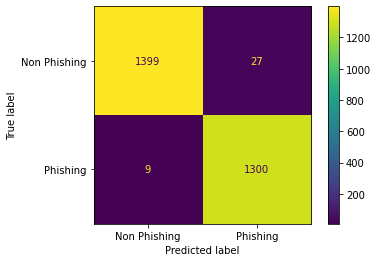

In [98]:
cm = confusion_matrix(y_test, pred)
plot = ConfusionMatrixDisplay(cm, ['Non Phishing', 'Phishing'])
plot.plot()

In [104]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm

In [106]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [108]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [111]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [114]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [115]:
# df['Text'] = df['Text'].apply(lambda x: x.lower())
# df['Text'] = df['Text'].apply(lambda x: word_tokenize(x))

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(df['Text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'text_final'] = str(Final_words)

In [129]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text_final'], df['Class'],test_size=0.3)

In [130]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [127]:
df['text_final'].describe()
df['text_final']=df['text_final'].astype(str)

In [131]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
pipe_svm = Pipeline([('clf', SVC(random_state=42))])

pipe_lr = Pipeline([('clf', LogisticRegression())])

In [100]:

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'],
                    'clf__C': list(range(1, 11, 2))}]

grid_params_lr = [{"clf__C":np.logspace(-3,3,7),
                   "clf__penalty":["none","l1","l2"]}]

In [101]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [102]:
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=inner_cv)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=inner_cv,
			n_jobs=jobs)

grids = [gs_svm, gs_lr]

grid_dict = {0: 'SVM',
             1: 'Logistic Regression'}

Performing model optimizations...

Estimator: SVM
Best params: {'clf__C': 1, 'clf__kernel': 'rbf'}
Best training accuracy: 0.427
Test set accuracy score for best params: 0.425 

Estimator: Logistic Regression
Best params: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Best training accuracy: 0.438
Test set accuracy score for best params: 0.429 

Classifier with best test set accuracy: Logistic Regression


C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jayan\AppData\Local\Programs\Pytho

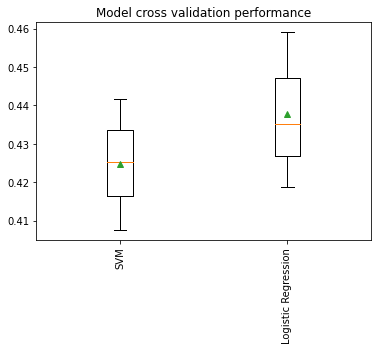

In [134]:
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
clf_dict, cv_results = dict(), dict()
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(Train_X_Tfidf, Train_Y)
    clf_dict[idx] = gs
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Outer cross validation loop
    cv_scores = cross_val_score(gs, Train_X_Tfidf, Train_Y, cv=outer_cv)
    cv_results[grid_dict[idx]] = cv_scores
    # Predict on test data with best params
    y_pred = gs.predict(Test_X_Tfidf)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % metrics.accuracy_score(Test_Y, y_pred))
    # Track best (highest test accuracy) model
    if metrics.accuracy_score(Test_Y, y_pred) > best_acc:
        best_acc = metrics.accuracy_score(Test_Y, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
# plot model performance for comparison
plt.boxplot(list(cv_results.values()), labels=list(cv_results.keys()), showmeans=True)
plt.xticks(rotation = 90)
plt.title('Model cross validation performance')
plt.show()

In [135]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  41.913303437967116


In [ ]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
    'early_stopping_rounds': 2000,
    'use_best_model': True,
    'verbose': 500
}
class_weight = [5,4]
model = CatBoostClassifier(**catboost_params,class_weights=class_weight)
model.fit(train_pool, eval_set=valid_pool)

In [ ]:
pred = model.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

In [ ]:
s = '''
<div id=":31" class="a3s aiL "><u></u>








<div style="vertical-align:baseline;text-align:center;color:#333;font-style:normal;font-variant:normal;font-weight:normal;font-size:14px;line-height:1.5em;font-family:Helvetica,Arial,sans-serif;background-color:#ddd;margin:0px;padding:40px 0;border:0" bgcolor="#ddd">





<div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;max-width:840px;box-sizing:border-box;background-color:#f5f5f5;margin:0 20px;padding:18px;border:10px solid #fff">


	<div style="font-size:16px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;border-top-color:#dddddd;border-top-style:solid;border-bottom-style:solid;border-bottom-color:#dddddd;margin:0 0 10px 0;padding:8px 0;border-width:1px 0">
		<strong style="font-size:normal;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;margin:0;padding:0;border:0">Receipt</strong>
	</div>


	<header style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;display:block;overflow:hidden;margin:0;padding:40px 0 20px;border:0"><div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;float:left;width:180px;text-align:left;margin:0;padding:0;border:0;display:block" align="left">
			<img src="https://ci6.googleusercontent.com/proxy/RfY8rWZbVzLloTt2s5ze2d4lV_MG5ZZNBKkHjYv4gLI-Giv2KCMMS0IaWFx21H4c7WOwrPv46VkonSTBYG5it6JguJkUZs0aP8swNVLk51Z3ktkIafcZyxra58S5PBhfkRzCEkSokQ=s0-d-e1-ft#http://s3media.corethree.net/clients/firstgroupbus/firstgroupbuses-icon-receipts.png" style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline" class="CToWUd">
		</div>

		<dl style="font-size:normal;line-height:1.5em;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;overflow:hidden;text-align:left;float:left;width:70%;margin:0;padding:0;border:0">
<h2 style="font-size:38px;line-height:normal;font-family:Helvetica,sans-serif;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;clear:both;margin:0 0 10px 0;padding:0;border:0">See you soon...</h2>
			<p style="font-size:18px;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;margin:0;padding:0;border:0">Thank you for buying your ticket from First in the West of England.  We hope to welcome you on the bus soon.</p>
		</dl></header>

		<p style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:center;margin:0 0 20px 0;padding:0;border:0;display:block;clear:both">&nbsp;<br>If you're having issues with your purchase, please contact the mTicket support team by selecting “Info“ in the First Bus app, to get an instant answer with one of our live chat agents. Alternatively, you can call or send a webform using the details displayed in the app. Our contact details are also displayed <a href="https://www.firstbus.co.uk/buy-ticket/mtickets-customer-service" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://www.firstbus.co.uk/buy-ticket/mtickets-customer-service&amp;source=gmail&amp;ust=1640700693223000&amp;usg=AOvVaw3pedJ2lede1K44JUbZqP_K">here</a> on the website.</p>

		<section style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;display:block;overflow:hidden;margin:0;padding:0;border:0">
			<div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;float:left;width:30%;margin:0;padding:0 0 30px;border:0;display:block;min-width:160px" align="left">
				<h2 style="font-size:16px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;border-bottom-color:#dddddd;border-bottom-style:solid;margin:0 0 4px;padding:0 0 4px;border-width:0 0 1px">Purchase Details:</h2>
				<div style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
					<strong>Receipt Ref:</strong><br>
					xmWtnTAZKoO<br><br>
					<strong>Date of Purchase:</strong><br>
					27 December 2021
				</div>
			</div>

			<div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;float:left;width:30%;margin:0 5% 0 0;padding:0 0 30px;border:0;display:block;min-width:160px" align="left">
			<h2 style="font-size:16px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;border-bottom-color:#dddddd;border-bottom-style:solid;margin:0 0 4px;padding:0 0 4px;border-width:0 0 1px">Your details:</h2>
			<div style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
					John Anwana<br>
					<br>
					<br>
					<br>

			</div>
		</div>

		<div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;float:left;width:30%;margin:0 5% 0 0;padding:0 0 30px;border:0;display:block;min-width:160px" align="left">
			<h2 style="font-size:16px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;border-bottom-color:#dddddd;border-bottom-style:solid;margin:0 0 4px;padding:0 0 4px;border-width:0 0 1px">Payment to:</h2>
			<div style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
				First Bristol<br>
				Enterprise House<br>
				Easton Road<br>
				Bristol<br>
				BS5 0DZ
			</div>
		</div>
	</section>

	<section style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;display:block;margin:0;padding:0;border:0;clear:both"><div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;margin:0;padding:0 0 30px;border:0" align="left">
			<table style="font-size:12px;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;border-collapse:collapse;border-spacing:0;width:100%;margin:0;padding:0;border:0;clear:left">
<caption style="font-size:16px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;border-bottom-color:#dddddd;border-bottom-style:solid;text-align:left;margin:0 0 4px;padding:0 0 4px;border-width:0 0 1px">Your Receipt</caption>
				<thead style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline"><tr style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
<th style="font-size:normal;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;background-color:#e5e5e5;margin:0;padding:6px 0 6px 8px;border:0;text-align:left" bgcolor="#e5e5e5" valign="baseline">Item &amp; Description</th>
						<th style="font-size:normal;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;background-color:#e5e5e5;margin:0;padding:6px 0;border:0;text-align:center" bgcolor="#e5e5e5" valign="baseline">Quantity</th>
						<th style="font-size:normal;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;text-align:right;background-color:#e5e5e5;margin:0;padding:6px 8px 6px 0;border:0" align="right" bgcolor="#e5e5e5" valign="baseline">Price</th>
					</tr></thead>
<tbody style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
          <tr style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
<th style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;background-color:#fff;margin:0;padding:6px 0 6px 8px;border:0;text-align:left" bgcolor="#fff" valign="baseline">Single-Student-Bristol Zone</th>
						<td style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;background-color:#fff;margin:0;padding:6px 0 6px 8px;border:0;text-align:center" bgcolor="#fff" valign="baseline">1</td>
						<td style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:right;background-color:#fff;margin:0;padding:6px 8px 6px 0;border:0" align="right" bgcolor="#fff" valign="baseline">£1.60</td>
					</tr>
				</tbody>
</table>
</div>


		<div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;margin:0;padding:0 0 30px;border:0" align="left">
			<table style="font-size:12px;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;border-collapse:collapse;border-spacing:0;width:100%;margin:0;padding:0;border:0"><tbody style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline"><tr style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
<th style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;background-color:#fff;margin:0;padding:6px 0 6px 8px;border:0;text-align:left" bgcolor="#fff" valign="baseline">Total:</th>
						<td style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;background-color:#fff;margin:0;padding:6px 0 6px 8px;border:0" bgcolor="#fff" valign="baseline"></td>
						<td style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:right;background-color:#fff;margin:0;padding:6px 8px 6px 0;border:0" align="right" bgcolor="#fff" valign="baseline">£1.60</td>
					</tr></tbody></table>
</div>


		<div style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;text-align:left;margin:0;padding:0 0 30px;border:0" align="left">
			<h6 style="font-size:16px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;border-bottom-color:#dddddd;border-bottom-style:solid;margin:0 0 4px;padding:0 0 4px;border-width:0 0 1px">Terms &amp; Conditions:</h6>
			<p style="font-size:normal;line-height:normal;font-style:normal;font-weight:normal;font-variant:normal;vertical-align:baseline;margin:0;padding:0 0 1em;border:0">Please make sure you have read and understand the conditions under which First Bus provides tickets for use through our Mobile App for mTickets.  These can be found in full on the app (under 'More') or by <a href="https://protect-eu.mimecast.com/s/eDMtCY7WXTMrNvWT07vpy?domain=firstgroup.com" target="_blank" data-saferedirecturl="https://www.google.com/url?q=https://protect-eu.mimecast.com/s/eDMtCY7WXTMrNvWT07vpy?domain%3Dfirstgroup.com&amp;source=gmail&amp;ust=1640700693223000&amp;usg=AOvVaw0liGZMPT1mQy5tK7-2SOMk">clicking here</a>.</p>
		</div>

	</section><footer style="font-size:12px;line-height:normal;font-style:normal;font-weight:bold;font-variant:normal;vertical-align:baseline;display:block;border-top-style:solid;border-top-color:#dddddd;margin:0;padding:18px 0 0;border-width:1px 0 0"><p style="font-size:normal;border:0;font-style:normal;font-variant:normal;padding:0;line-height:normal;margin:0;font-weight:normal;vertical-align:baseline">
			Mobile Ticketing is promoted and operated by FirstGroup PLC<br>
			Registered in Scotland, No.SC157176.
		</p>
	</footer><div class="yj6qo"></div><div class="adL">
</div></div><div class="adL">


</div></div><div class="adL">


</div></div>'''

In [ ]:
print(remove_special_chars(strip_tags(s)))